# Scaling TTI equations from Fletcher et al

In [1]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm 
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
from scipy.ndimage import gaussian_filter

## Transforming equations from 3d to 2d

Fletcher et al. 2009 defines a coupled PDE system from a P-SV TTI dispersion relation as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H_2 p + \alpha v_{pz}^2 H_1 q + v_{sz}^2 H_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H_2 p + v_{pz}^2 H_1 q - v_{sz}^2 H_2 \left( \frac{1}{\alpha} p - q \right)$

Where $v_{pz}$ is the P-wave velocity in the direction normal to the symmetry plane, $v_{pn} = v_{pz}\sqrt{1 + 2\delta}$ with $v_{pn}$ being the P-wave NMO velocity, $v_{px} = v_{pz}\sqrt{1 + 2\epsilon}$ with $v_{px}$ being the P-wave velocity in the symmetry plane, $v_{sz}$ is the SV velocity normal to the symmetry plane, $\delta$ and $\epsilon$ are anisotropy parameters defined by Thomsen 1986 and $\alpha$ is a non-zero scalar used to parameterise the equations. $H_1$ and $H_2$ are derivative operators defined as:

$H_1 = \sin^2\theta \cos^2\phi \frac{\partial^2}{\partial x^2} + \sin^2\theta \sin^2\phi \frac{\partial^2}{\partial y^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin^2\theta \sin 2\phi \frac{\partial^2}{\partial x \partial y} + \sin 2\theta \sin\phi \frac{\partial^2}{\partial y \partial z} + \sin 2\theta \cos\phi \frac{\partial^2}{\partial x \partial z} $

$H_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} - H_1$

The operators above are three dimensional, so to solve the equations in two dimensions we set $\frac{\partial}{\partial y}$ and $\phi$ equal to zero. This leads to two dimensional derivative operators defined as:

$H'_1 = \sin^2\theta \frac{\partial^2}{\partial x^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin 2\theta \frac{\partial^2}{\partial x \partial z} $

$H'_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial z^2} - H'_1$

Using these two dimensional operators, we define a new set of coupled PDEs as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H'_2 p + \alpha v_{pz}^2 H'_1 q + v_{sz}^2 H'_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H'_2 p + v_{pz}^2 H'_1 q - v_{sz}^2 H'_2 \left( \frac{1}{\alpha} p - q \right)$

Below, we implement this 2d coupled system using a $v_{pz}$ of 3000m/s, a $v_{sz}$ of zero, $\epsilon$ of 0.24, $\delta$ of 0.1, $\theta$ of 45 degrees and an $\alpha$ of 1

In [17]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# constants, delta, epsilon and alpha are dimensionless, theta is radians, f0 is kHz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 0.03
}

# velocities in km/s
v = {
    "pz": 3,
    "px": 3 * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": 3 * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((3**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# define dt using the cfl condition, c=0.6
vmax = max(v["pz"], v["px"], v["pn"], v["sz"])
dt = np.amin(grid.spacing)*0.6/vmax

# define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# defining derivative operator functions
def h1(function, theta):
    operator = dv.sin(theta)**2*function.dx2 + dv.cos(theta)**2*function.dz2 + dv.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# defining equations
theta = constants["theta"]
alpha = constants["alpha"]

eq_p = p.dt2 - v["px"]**2 * h2(p, theta) - alpha * v["pz"]**2 * h1(q, theta) - v["sz"]**2 * (h1(p, theta) - alpha * h1(q, theta))
eq_q = q.dt2 - (v["pn"]**2 / alpha) * h2(p, theta) - v["pz"]**2 * h1(q, theta) + v["sz"]**2 * ((1 / alpha) * h2(p, theta) - h2(q, theta))

# defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.08467400000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=6.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

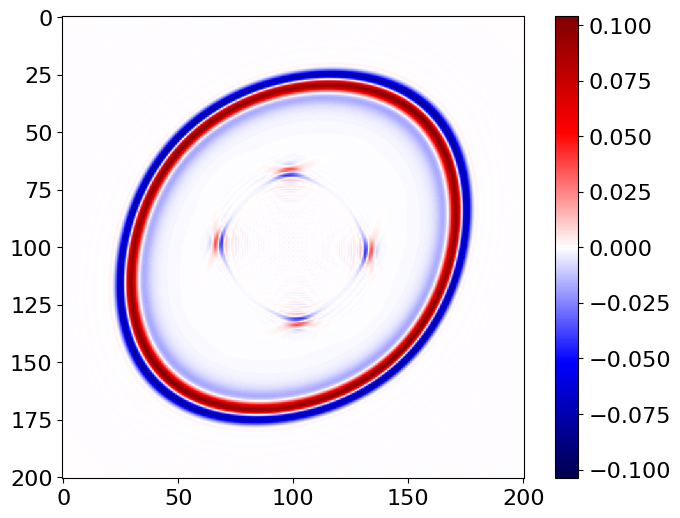

In [18]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

## Scaling for a constant parameter model

Here, we apply the same scaling technique as defined in [`unit-scaling-acoustic.ipynb`](./unit-scaling-acoustic.ipynb) to the coupled PDE system defined above. 

We first use the natural spatial unit of the problem (10m) to re-define our velocities from above (i.e. $v_{pz}$ = 3000m/s, $v_{px} = v_{pz}\sqrt{1+2\epsilon}$ m/s etc). This leads us to new velocities of $v_{pz}$ = 300(10m)/s, $v_{px}$ = 300 $\sqrt{1+2\epsilon}$ (10m)/s and $v_{pn}$ = 300 $\sqrt{1+2\delta}$ (10m)/s. 

We then use our new value of $v_{max}$ (our scaled $v_{px}$ of 300 $\sqrt{1+2\epsilon}$ (10m)/s) to calculate the timestep $\Delta t$ using the CFL condition with $c$ = 1 and $\Delta x$ = 1 (10m), finding $\Delta t$ to be $\frac{1}{300\sqrt{1+2\epsilon}}$ s.

Using this $\Delta t$ of $\frac{1}{300\sqrt{1+2\epsilon}}$ s, we define a new time unit of $\frac{1}{300\sqrt{1+2\epsilon}}$ s, rather than the SI unit of seconds.

Applying this time unit to our all time-dependent parameters leads to a new set of velocities, timestep, frequency and length $t_n$ of the simulation.

Using the new time unit, our velocities become: $v_{pz}$ = $\frac{300}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), $v_{pn}$ = $\frac{300\sqrt{1+2\delta}}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), and $v_{px}$ = $\frac{300\sqrt{1+2\epsilon}}{300\sqrt{1+2\epsilon}}$ (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s) = 1 (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s).

Using this new maximum velocity of 1 (10m)/($\frac{1}{300\sqrt{1+2\epsilon}}$ s), we can re-define $\Delta t$ using the CFL condition. This leads to a $\Delta t$ of 1 ($\frac{1}{300\sqrt{1+2\epsilon}}$ s) when using a Courant number of 1. The timestep here will always be equal to the Courant number selected.

We must also redefine the source frequency using the new time unit, leading to $f$ = 0.082Hz / ($\frac{1}{300\sqrt{1+2\epsilon}}$ s), (or 30Hz/s).

The length of the simulation $t_n$ is also affected by the new time unit. When scaling the grid, we reduce the extent by a factor of 10 so must reduce the simulation time by the same factor, bringing it from 250s to 25s. From here, we apply the time unit, multiplying the inital 25 s by $300\sqrt{1+2\epsilon}$.

Note that $v_{sz}$ is left unchanged, as this is set to zero in the simulation. The anisotropy parameters $\delta$ and $\epsilon$ are dimensionless so do not factor in to the scaling process as there are no units to scale. $\alpha$ is a non-zero scalar set to 1 so we have left this, and $\theta$ is left as $\sin\theta$ and $\cos\theta$ will always be between -1 and 1.

In [19]:
# setting up a new grid 
scaled_extent = (200, 200)
scaled_grid = dv.Grid(extent=scaled_extent, shape=shape, dimensions=(x, z))

# creating functions for the two scaled pressure fields
p_s = dv.TimeFunction(name='p_s', grid=scaled_grid, space_order=8, time_order=2)
q_s = dv.TimeFunction(name='q_s', grid=scaled_grid, space_order=8, time_order=2)

# defining constants and calculating velocities, scaling so the maximum is 1

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 0.082
}

# velocities in 10m/s
v = {
    "pz": 300,
    "px": 300 * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": 300 * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((300**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}
# pull maximum velocity to scale others 
vmax = max(v["pz"], v["px"], v["pn"], v["sz"])

# velocities in (10m)/(1/(vmax) s)
scaled_v = {
    "pz": v["pz"]/vmax,
    "px": v["px"]/vmax,
    "pn": v["pn"]/vmax,
    "sz": v["sz"]/vmax
}

# define new dt using the cfl condition
scaled_vmax = max(scaled_v["pz"], scaled_v["px"], scaled_v["pn"], scaled_v["sz"])
scaled_dt = np.amin(scaled_grid.spacing)*0.6/scaled_vmax

# define a new time range for the source term
t0 = 0
scaled_tn = 0.25*(vmax)
scaled_time_range = TimeAxis(start=t0, stop=scaled_tn, step=scaled_dt)

# creating source term, f=0.082 Hz 
scaled_src = RickerSource(name='src', grid=scaled_grid, f0=constants["f0"], npoint=1, time_range=scaled_time_range)
# setting source to the middle of the grid
scaled_src.coordinates.data[:] = [100., 100.]

# Defining equations using values from dictionaries
theta = constants["theta"]
alpha = constants["alpha"]

# Equations using scaled velocities from the 'scaled_v' dictionary
scaled_eq_p = p_s.dt2 - scaled_v["px"]**2 * h2(p_s, theta) - alpha * scaled_v["pz"]**2 * h1(q_s, theta) - scaled_v["sz"]**2 * (h1(p_s, theta) - alpha * h1(q_s, theta))
scaled_eq_q = q_s.dt2 - (scaled_v["pn"]**2 / alpha) * h2(p_s, theta) - scaled_v["pz"]**2 * h1(q_s, theta) + scaled_v["sz"]**2 * ((1 / alpha) * h2(p_s, theta) - h2(q_s, theta))

# injecting the source term to the pressure field, edit expr to vary source term
scaled_src_p = scaled_src.inject(field=p_s.forward, expr=scaled_src)
scaled_src_q = scaled_src.inject(field=q_s.forward, expr=scaled_src)

# defining stencils
scaled_stencil_p = dv.Eq(p_s.forward, dv.solve(scaled_eq_p, p_s.forward))
scaled_stencil_q = dv.Eq(q_s.forward, dv.solve(scaled_eq_q, q_s.forward))

# set up operator
new_op = dv.Operator([scaled_stencil_p, scaled_stencil_q] + scaled_src_p + scaled_src_q)
new_op(dt=scaled_dt)

Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.08528500000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

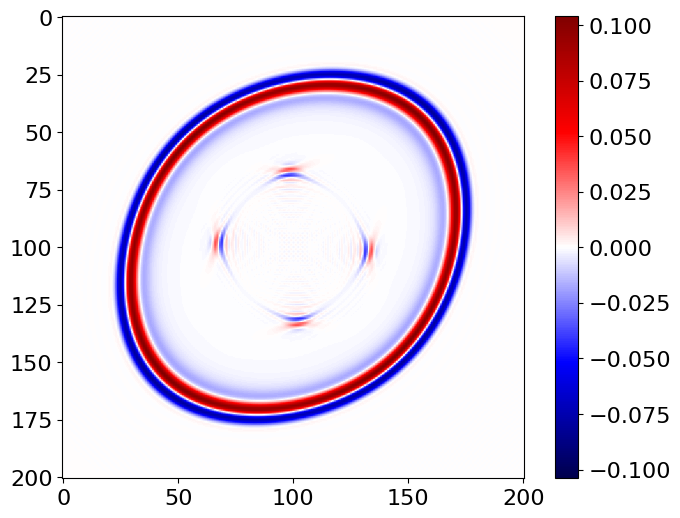

In [20]:
vmax = np.amax(np.abs(p_s.data[0]))
plt.imshow(p_s.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

### Visualing the difference between the scaled and unscaled constant parameter propagation

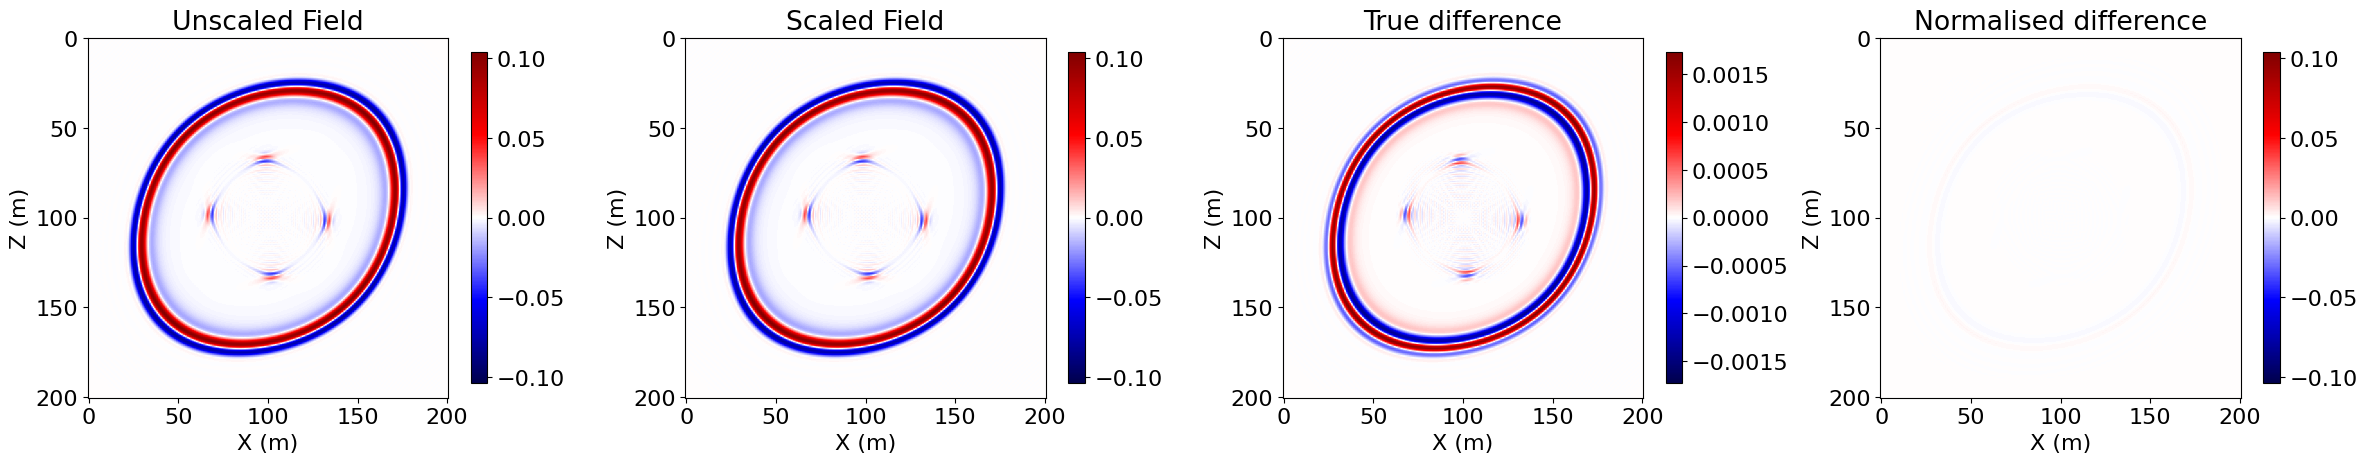

Maximum value of the difference: 0.0017294791
Minimum value of the difference: -0.0014370196


In [22]:
# replace p.data and p_s.data with whichever two fields you want to compute the diff of
unscaled_field = p.data[0]
scaled_field = p_s.data[0]
diff_field = (unscaled_field - scaled_field)  # Compute the difference

# Calculate maximum values for color scaling
vmax_unscaled = np.amax(np.abs(unscaled_field))
vmax_scaled = np.amax(np.abs(scaled_field))
vmax_diff = np.amax(np.abs(diff_field))

# Create a figure with 3 subplots in one row
fig, ax = plt.subplots(1, 4, figsize=(24, 6))  # 1 row, 3 columns

# Plot unscaled field
im1 = ax[0].imshow(unscaled_field, cmap='seismic', vmin=-vmax_unscaled, vmax=vmax_unscaled)
ax[0].set_title("Unscaled Field")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Z (m)")
fig.colorbar(im1, ax=ax[0], shrink=0.6)

# Plot scaled field
im2 = ax[1].imshow(scaled_field, cmap='seismic', vmin=-vmax_scaled, vmax=vmax_scaled)
ax[1].set_title("Scaled Field")
ax[1].set_xlabel("X (m)")
ax[1].set_ylabel("Z (m)")
fig.colorbar(im2, ax=ax[1], shrink=0.6)

# Plot the true difference field
# use the vmax and vmin of either the scaled or unscaled field to normalise the diff against this
im3 = ax[2].imshow(diff_field, cmap='seismic',  vmin=-vmax_diff, vmax=vmax_diff)
ax[2].set_title("True difference")
ax[2].set_xlabel("X (m)")
ax[2].set_ylabel("Z (m)")
fig.colorbar(im3, ax=ax[2], shrink=0.6)

# Plot the normalised difference field
# use the vmax and vmin of either the scaled or unscaled field to normalise the diff against this
im4 = ax[3].imshow(diff_field, cmap='seismic',  vmin=-vmax_unscaled, vmax=vmax_unscaled)
ax[3].set_title("Normalised difference")
ax[3].set_xlabel("X (m)")
ax[3].set_ylabel("Z (m)")
fig.colorbar(im4, ax=ax[3], shrink=0.6)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# couple of print statements to show the max/min difference
print("Maximum value of the difference:", np.amax(diff_field))
print("Minimum value of the difference:", np.amin(diff_field))

### Defining a variable velocity model

Here we define a variable velocity model for $V_{pz}$ which will be used as the base velocity to calculate the others. We use a series of sinusoidal functions to produce a model with more complex layering

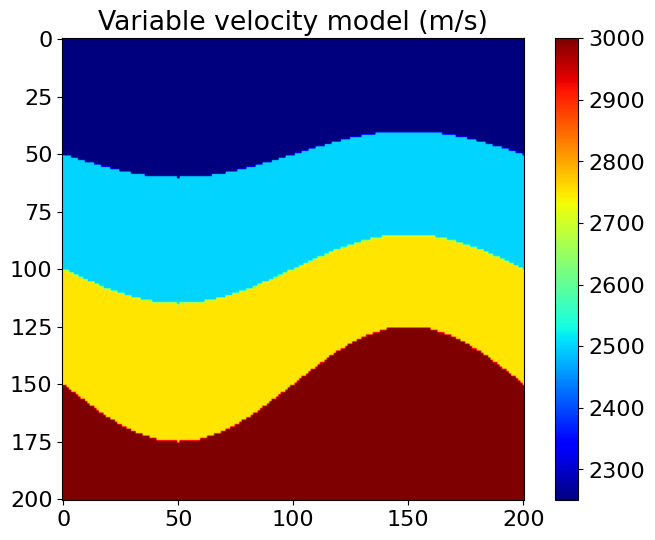

In [7]:
# Define a Devito Function for the velocity model
vp = dv.Function(name='vp', grid=grid)
# Create x, z coordinates for the meshgrid
x, z = grid.dimensions
x_vals, z_vals = np.meshgrid(np.linspace(0, 200, 201), np.linspace(0, 200, 201), indexing='ij')

# Define the velocity model with sinusoidal boundaries
vp.data[:] = 2250  # Top layer
vp.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 2500  # Second layer with sinusoidal boundary
vp.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 2750  # Third layer with sinusoidal boundary
vp.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 3000  # Fourth layer with sinusoidal boundary

# Apply Gaussian smoothing to smooth out the boundaries
smooth = 2  # You can adjust the sigma value to control the smoothness
#vp.data[:] = gaussian_filter(vp.data, sigma=smooth)

plt.imshow(vp.data.T, cmap='jet', interpolation='hanning')
plt.title('Variable velocity model (m/s)')
plt.colorbar()
plt.show()

### Propagating through the variable velocity model

Below we implement the coupled TTI system through the variable velocity model, unscaled. In this example, the velocity is the only variable with $\epsilon$ and $\delta$ being constant.

In [8]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 30
}

# Now use the Function objects directly in the velocity dictionary
v = {
    "pz": vp,
    "px": vp * dv.sqrt(1 + 2*constants["epsilon"]),
    "pn": vp * dv.sqrt(1 + 2*constants["delta"]),
    "sz": dv.sqrt((vp**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# Calculate the maximum value for each velocity field using their .data
# vmax = max(np.max(v["pz"].data), np.max(v["px"].data), np.max(v["pn"].data), np.max(v["sz"].data))
vmax = max(np.amax(vp.data*np.sqrt(1+2*constants["epsilon"])), np.amax(vp.data*np.sqrt(1+2*constants["delta"])))

# Define dt using the CFL condition, c=0.6
dt = float(np.amin(grid.spacing) * 0.6 / vmax)

# define a time range for the source term
t0 = 0
tn = 0.25
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# defining equations
theta = constants["theta"]
alpha = constants["alpha"]

# define equations
eq_p = p.dt2 - v["px"]**2 * h2(p, theta) - alpha * v["pz"]**2 * h1(q, theta) - v["sz"]**2 * (h1(p, theta) - alpha * h1(q, theta))
eq_q = q.dt2 - (v["pn"]**2 / alpha) * h2(p, theta) - v["pz"]**2 * h1(q, theta) + v["sz"]**2 * ((1 / alpha) * h2(p, theta) - h2(q, theta))

# # defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# # set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.14 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.13342100000000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

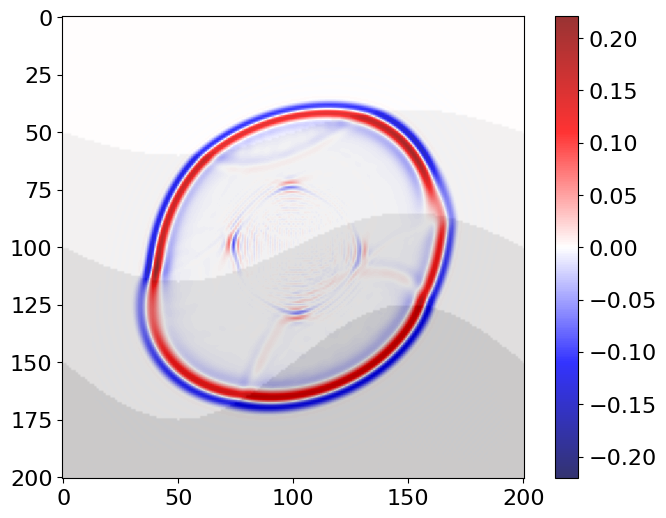

In [9]:
vmax = np.amax(np.abs(p.data[0]))
plt.figure(figsize=(8, 6))
plt.imshow(vp.data.T, cmap='Greys', interpolation='hanning')
plt.imshow(p.data[0].T, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)
plt.colorbar()
plt.show()

### Scaling with maximum velocity

Here, we apply the process of scaling the variable velocity model using the maximum velocity. First, we drop everything into (10m)/s to make use of the natural spatial unit of the problem. We then find a value for $\Delta t$ using this new velocity and define a new time unit that normalises $\Delta t$. We then apply the new time unit to all of the time dependent parameters in the problem (velocity, frequency, simulation length)

In [10]:
# creating functions for the two scaled pressure fields
p_s = dv.TimeFunction(name='p_s', grid=scaled_grid, space_order=8, time_order=2)
q_s = dv.TimeFunction(name='q_s', grid=scaled_grid, space_order=8, time_order=2)

# defining constants and calculating velocities, scaling so the maximum is 1

# Define a Devito Function for the velocity model
vp = dv.Function(name='vp', grid=scaled_grid)
# Create x, z coordinates for the meshgrid
x, z = scaled_grid.dimensions
x_vals, z_vals = np.meshgrid(np.linspace(0, 200, 201), np.linspace(0, 200, 201), indexing='ij')

# Define the velocity model with sinusoidal boundaries
vp.data[:] = 2250  # Top layer
vp.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 2500  # Second layer with sinusoidal boundary
vp.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 2750  # Third layer with sinusoidal boundary
vp.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 3000  # Fourth layer with sinusoidal boundary

# convert the velocity model to (10m)/s
vp.data[:] /= 10

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": 0.1,
    "epsilon": 0.24,
    "sigma": 0.75,
    "theta": sp.pi/4,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    # actually define it as 30/vmax and it works
    "f0": 1/60*np.sqrt(37) # defined as 30/vmax 
}

# velocities in 10m/s
v = {
    "pz": vp,
    "px": vp * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": vp * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((vp**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# pull maximum velocity to scale others 
vmax = float(max(np.amax(vp.data*np.sqrt(1+2*constants["epsilon"])), np.amax(vp.data*np.sqrt(1+2*constants["delta"]))))

# velocities in (10m)/(1/(vmax) s)
scaled_v = {
    "pz": v["pz"]/vmax,
    "px": v["px"]/vmax,
    "pn": v["pn"]/vmax,
    "sz": v["sz"]/vmax
}

# define new dt using the cfl condition
scaled_vmax = 1
scaled_dt = np.amin(scaled_grid.spacing)*0.6/scaled_vmax

# define a new time range for the source term
t0 = 0
scaled_tn = 0.25*(vmax)
scaled_time_range = TimeAxis(start=t0, stop=scaled_tn, step=scaled_dt)

# creating source term, f=0.082 Hz 
scaled_src = RickerSource(name='src', grid=scaled_grid, f0=30/vmax, npoint=1, time_range=scaled_time_range, interpolation='sinc')
# setting source to the middle of the grid
scaled_src.coordinates.data[:] = [100., 100.]

# Defining equations using values from dictionaries
theta = constants["theta"]
alpha = constants["alpha"]

# defining derivative operator functions
def h1(function, theta):
    operator = dv.sin(theta)**2*function.dx2 + dv.cos(theta)**2*function.dz2 + dv.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# Equations using scaled velocities from the 'scaled_v' dictionary
scaled_eq_p = p_s.dt2 - scaled_v["px"]**2 * h2(p_s, theta) - alpha * scaled_v["pz"]**2 * h1(q_s, theta) - scaled_v["sz"]**2 * (h1(p_s, theta) - alpha * h1(q_s, theta))
scaled_eq_q = q_s.dt2 - (scaled_v["pn"]**2 / alpha) * h2(p_s, theta) - scaled_v["pz"]**2 * h1(q_s, theta) + scaled_v["sz"]**2 * ((1 / alpha) * h2(p_s, theta) - h2(q_s, theta))

# injecting the source term to the pressure field, edit expr to vary source term
scaled_src_p = scaled_src.inject(field=p_s.forward, expr=scaled_src)
scaled_src_q = scaled_src.inject(field=q_s.forward, expr=scaled_src)

# defining stencils
scaled_stencil_p = dv.Eq(p_s.forward, dv.solve(scaled_eq_p, p_s.forward))
scaled_stencil_q = dv.Eq(q_s.forward, dv.solve(scaled_eq_q, q_s.forward))

# set up operator
new_op = dv.Operator([scaled_stencil_p, scaled_stencil_q] + scaled_src_p + scaled_src_q)
new_op(dt=scaled_dt)

Operator `Kernel` ran in 0.14 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.1389299999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.499999999999997e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

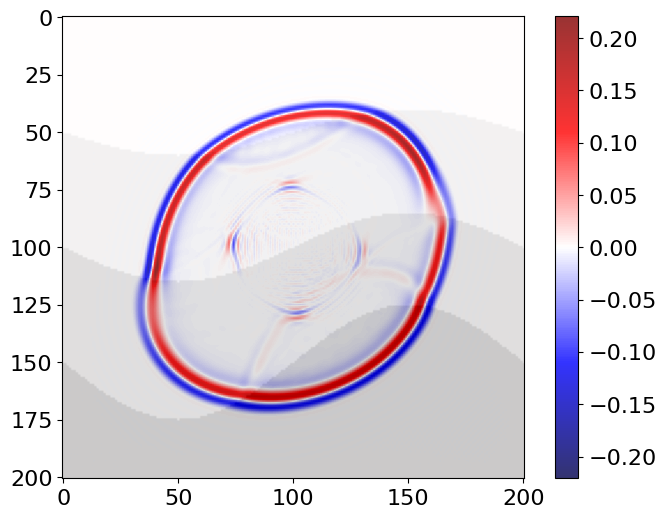

In [11]:
vmax = np.amax(np.abs(p_s.data[0]))
plt.figure(figsize=(8, 6))
plt.imshow(vp.data.T, cmap='Greys', interpolation='hanning')
plt.imshow(p_s.data[0].T, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)
plt.colorbar()
plt.show()

### Propagation through variable velocity, theta, delta and epsilon model

To demonstrate that the scaling method is indifferent to variation in the parameters, we create variable models for the tilt angle $\theta$ as well as the anisotropy parameters $\epsilon$ and $\delta$. In our implementation we integrate this with the variable velocity model.

In [12]:
# propagation through variable velocity, epsilon and delta

# creating functions for the two pressure fields
p_v = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q_v = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# Create Devito Functions for epsilon and delta
epsilon = dv.Function(name='epsilon', grid=grid)
delta = dv.Function(name='delta', grid=grid)

# Define the layers for epsilon and delta, ensuring epsilon is greater than delta
epsilon.data[:] = 0.24  # Top layer
epsilon.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 0.26  # Second layer with sinusoidal boundary
epsilon.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 0.28  # Third layer with sinusoidal boundary
epsilon.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 0.3 

# Define corresponding delta values (ensuring they are smaller than epsilon)
delta.data[:] = 0.1  # Top layer
delta.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 0.12  # Second layer with sinusoidal boundary
delta.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 0.14  # Third layer with sinusoidal boundary
delta.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 0.16 # Layer 4

# Define a Devito Function for the velocity model
vp = dv.Function(name='vp', grid=grid)
# Create x, z coordinates for the meshgrid
x, z = grid.dimensions
x_vals, z_vals = np.meshgrid(np.linspace(0, 200, 201), np.linspace(0, 200, 201), indexing='ij')

# Define the velocity model with sinusoidal boundaries
vp.data[:] = 2250  # Top layer
vp.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 2500  # Second layer with sinusoidal boundary
vp.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 2750  # Third layer with sinusoidal boundary
vp.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 3000 

# Create Devito Function for tilt (theta)
theta = dv.Function(name='theta', grid=grid)

# Define the boundaries used in the velocity model
boundary_1 = 50 + 10*np.sin(2*np.pi*x_vals/200)  # First boundary
boundary_2 = 100 + 15*np.sin(2*np.pi*x_vals/200)  # Second boundary
boundary_3 = 150 + 25*np.sin(2*np.pi*x_vals/200)  # Third boundary

# Compute the derivative (slope) for each boundary
slope_1 = 10 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_1
slope_2 = 15 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_2
slope_3 = 25 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_3

# Iterate through the grid to assign theta values based on conditions
for i in range(shape[0]):
    for j in range(shape[1]):
        if z_vals[i, j] <= boundary_1[i, j]:
            theta.data[i, j] = np.arctan(slope_1[i, j])
        elif boundary_1[i, j] < z_vals[i, j] <= boundary_2[i, j]:
            theta.data[i, j] = np.arctan(slope_2[i, j])
        elif boundary_2[i, j] < z_vals[i, j] <= boundary_3[i, j]:
            theta.data[i, j] = np.arctan(slope_3[i, j])
        else:
            theta.data[i, j] = 0  # Flat for the last layer

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": delta,
    "epsilon": epsilon,
    "sigma": 0.75,
    "theta": theta,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    "f0": 30
}

# Now use the Function objects directly in the velocity dictionary
v = {
    "pz": vp,
    "px": vp * dv.sqrt(1 + 2*constants["epsilon"]),
    "pn": vp * dv.sqrt(1 + 2*constants["delta"]),
    "sz": dv.sqrt((vp**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# Calculate the maximum value for each velocity field using their .data
# vmax = max(np.max(v["pz"].data), np.max(v["px"].data), np.max(v["pn"].data), np.max(v["sz"].data))
max_epsilon = float(np.max(epsilon.data))
max_delta = float(np.max(delta.data))
vmax = float(max(np.amax(vp.data*np.sqrt(1+2*max_epsilon)), np.amax(vp.data*np.sqrt(1+2*0.16))))

# Define dt using the CFL condition, c=0.6
dt = float(np.amin(grid.spacing) * 0.6 / vmax)

# define a time range for the source term
t0 = 0
tn = 0.25
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# defining equations
theta = constants["theta"]
alpha = constants["alpha"]

# defining derivative operator functions
def h1(function, theta):
    operator = dv.sin(theta)**2*function.dx2 + dv.cos(theta)**2*function.dz2 + dv.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# define equations
eq_p = p_v.dt2 - v["px"]**2 * h2(p_v, theta) - alpha * v["pz"]**2 * h1(q_v, theta) - v["sz"]**2 * (h1(p_v, theta) - alpha * h1(q_v, theta))
eq_q = q_v.dt2 - (v["pn"]**2 / alpha) * h2(p_v, theta) - v["pz"]**2 * h1(q_v, theta) + v["sz"]**2 * ((1 / alpha) * h2(p_v, theta) - h2(q_v, theta))

# # defining stencils
stencil_p = dv.Eq(p_v.forward, dv.solve(eq_p, p_v.forward))
stencil_q = dv.Eq(q_v.forward, dv.solve(eq_q, q_v.forward))

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p_v.forward, expr=src)
src_q = src.inject(field=q_v.forward, expr=src)

# # set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.15 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000517, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.14660599999999985, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=5.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

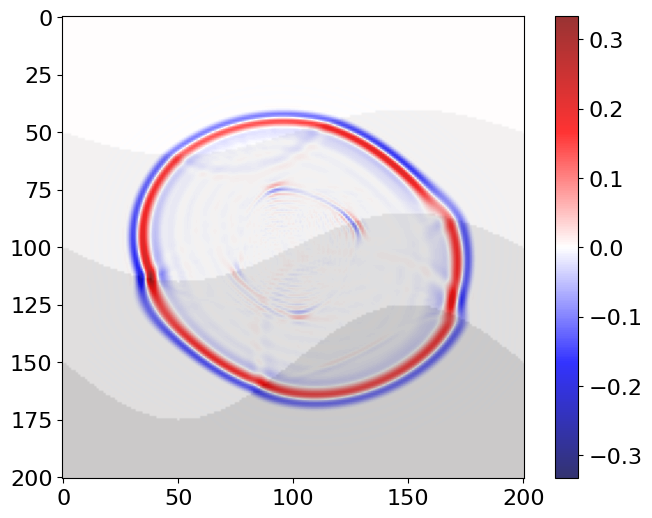

In [13]:
vmax = np.amax(np.abs(p_v.data[0]))
plt.figure(figsize=(8, 6))
plt.imshow(vp.data.T, cmap='Greys', interpolation='hanning')
plt.imshow(p_v.data[0].T, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)
plt.colorbar()
plt.show()

### Scaling with the variable parameter model

Here, we apply a similar scaling method using the maximum value for velocity. Since we now have a spatially varying field describing one of the values that determines velocity, we can extract the maximum values of $\epsilon$ and $\delta$ to compute our highest possible velocity and use this as the benchmark for normalisation. The rest of the method follows the same procedure as above, defining a maximum velocity in (10m)/s before finding $\Delta t$ defining a time unit to normalise and applying this time unit to the rest of the problem.

In [14]:
# creating functions for the two scaled pressure fields
p_sv = dv.TimeFunction(name='p_s', grid=scaled_grid, space_order=8, time_order=2)
q_sv = dv.TimeFunction(name='q_s', grid=scaled_grid, space_order=8, time_order=2)

# defining constants and calculating velocities, scaling so the maximum is 1

# Define a Devito Function for the velocity model
vp = dv.Function(name='vp', grid=scaled_grid)
# Create x, z coordinates for the meshgrid
x, z = scaled_grid.dimensions
x_vals, z_vals = np.meshgrid(np.linspace(0, 200, 201), np.linspace(0, 200, 201), indexing='ij')

# Define the velocity model with sinusoidal boundaries
vp.data[:] = 2250  # Top layer
vp.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 2500  # Second layer with sinusoidal boundary
vp.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 2750  # Third layer with sinusoidal boundary
vp.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 3000  # Fourth layer with sinusoidal boundary

# convert the velocity model to (10m)/s
vp.data[:] /= 10

# Create Devito Functions for epsilon and delta
epsilon = dv.Function(name='epsilon', grid=scaled_grid)
delta = dv.Function(name='delta', grid=scaled_grid)

# Define the layers for epsilon and delta, ensuring epsilon is greater than delta
epsilon.data[:] = 0.24  # Top layer
epsilon.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 0.26  # Second layer with sinusoidal boundary
epsilon.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 0.28  # Third layer with sinusoidal boundary
epsilon.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 0.3 

# Define corresponding delta values (ensuring they are smaller than epsilon)
delta.data[:] = 0.1  # Top layer
delta.data[z_vals > 50 + 10*np.sin(2*np.pi*x_vals/200)] = 0.12  # Second layer with sinusoidal boundary
delta.data[z_vals > 100 + 15*np.sin(2*np.pi*x_vals/200)] = 0.14  # Third layer with sinusoidal boundary
delta.data[z_vals > 150 + 25*np.sin(2*np.pi*x_vals/200)] = 0.16 # Layer 4

# Create Devito Function for tilt (theta)
theta = dv.Function(name='theta', grid=scaled_grid)

# Define the boundaries used in the velocity model
boundary_1 = 50 + 10*np.sin(2*np.pi*x_vals/200)  # First boundary
boundary_2 = 100 + 15*np.sin(2*np.pi*x_vals/200)  # Second boundary
boundary_3 = 150 + 25*np.sin(2*np.pi*x_vals/200)  # Third boundary

# Compute the derivative (slope) for each boundary
slope_1 = 10 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_1
slope_2 = 15 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_2
slope_3 = 25 * (2 * np.pi / 200) * np.cos(2 * np.pi * x_vals / 200)  # Derivative of boundary_3

# Iterate through the grid to assign theta values based on conditions
for i in range(shape[0]):
    for j in range(shape[1]):
        if z_vals[i, j] <= boundary_1[i, j]:
            theta.data[i, j] = np.arctan(slope_1[i, j])
        elif boundary_1[i, j] < z_vals[i, j] <= boundary_2[i, j]:
            theta.data[i, j] = np.arctan(slope_2[i, j])
        elif boundary_2[i, j] < z_vals[i, j] <= boundary_3[i, j]:
            theta.data[i, j] = np.arctan(slope_3[i, j])
        else:
            theta.data[i, j] = 0  # Flat for the last layer

# constants, sigma, epsilon and alpha are dimensionless, theta is radians, f0 is Hz
constants = {
    "delta": delta,
    "epsilon": epsilon,
    "sigma": 0.75,
    "theta": theta,  # Keep symbolic pi here for symbolic operations
    "alpha": 1,
    # actually define it as 30/vmax and it works
    "f0": 1/60*np.sqrt(37) # defined as 30/vmax 
}

# velocities in 10m/s
v = {
    "pz": vp,
    "px": vp * dv.sqrt(1 + 2 * constants["epsilon"]),
    "pn": vp * dv.sqrt(1 + 2 * constants["delta"]),
    "sz": dv.sqrt((vp**2/constants["sigma"])*(constants["epsilon"]-constants["delta"]))
}

# pull maximum velocity to scale others 
max_epsilon = float(np.max(epsilon.data))
max_delta = float(np.max(delta.data))
vmax = float(max(np.amax(vp.data*np.sqrt(1+2*max_epsilon)), np.amax(vp.data*np.sqrt(1+2*max_delta))))

# velocities in (10m)/(1/(vmax) s)
scaled_v = {
    "pz": v["pz"]/vmax,
    "px": v["px"]/vmax,
    "pn": v["pn"]/vmax,
    "sz": v["sz"]/vmax
}

# define new dt using the cfl condition
scaled_vmax = 1
scaled_dt = np.amin(scaled_grid.spacing)*0.6/scaled_vmax

# define a new time range for the source term
t0 = 0
scaled_tn = 0.25*(vmax)
scaled_time_range = TimeAxis(start=t0, stop=scaled_tn, step=scaled_dt)

# creating source term, f=0.082 Hz 
scaled_src = RickerSource(name='src', grid=scaled_grid, f0=30/vmax, npoint=1, time_range=scaled_time_range, interpolation='sinc')
# setting source to the middle of the grid
scaled_src.coordinates.data[:] = [100., 100.]

# Defining equations using values from dictionaries
theta = constants["theta"]
alpha = constants["alpha"]

# defining derivative operator functions
def h1(function, theta):
    operator = dv.sin(theta)**2*function.dx2 + dv.cos(theta)**2*function.dz2 + dv.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# Equations using scaled velocities from the 'scaled_v' dictionary
scaled_eq_p = p_sv.dt2 - scaled_v["px"]**2 * h2(p_sv, theta) - alpha * scaled_v["pz"]**2 * h1(q_sv, theta) - scaled_v["sz"]**2 * (h1(p_sv, theta) - alpha * h1(q_sv, theta))
scaled_eq_q = q_sv.dt2 - (scaled_v["pn"]**2 / alpha) * h2(p_sv, theta) - scaled_v["pz"]**2 * h1(q_sv, theta) + scaled_v["sz"]**2 * ((1 / alpha) * h2(p_sv, theta) - h2(q_sv, theta))

# injecting the source term to the pressure field, edit expr to vary source term
scaled_src_p = scaled_src.inject(field=p_sv.forward, expr=scaled_src)
scaled_src_q = scaled_src.inject(field=q_sv.forward, expr=scaled_src)

# defining stencils
scaled_stencil_p = dv.Eq(p_sv.forward, dv.solve(scaled_eq_p, p_sv.forward))
scaled_stencil_q = dv.Eq(q_sv.forward, dv.solve(scaled_eq_q, q_sv.forward))

# set up operator
new_op = dv.Operator([scaled_stencil_p, scaled_stencil_q] + scaled_src_p + scaled_src_q)
new_op(dt=scaled_dt)

Operator `Kernel` ran in 0.16 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.00066, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.15242900000000018, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=3.8999999999999986e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

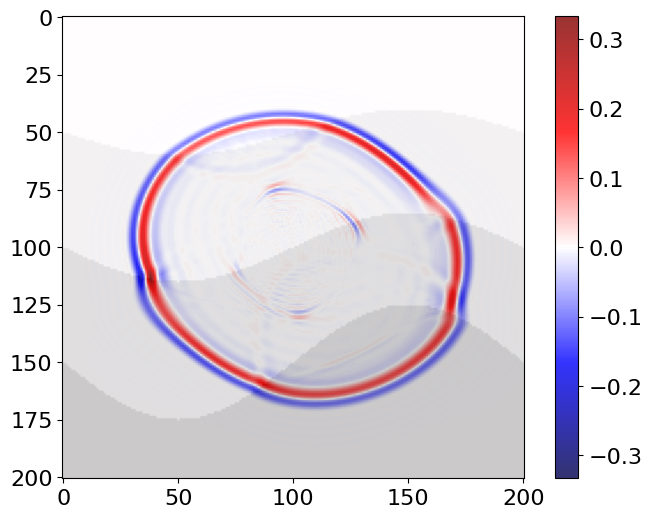

In [15]:
vmax = np.amax(np.abs(p_sv.data[0]))
plt.figure(figsize=(8, 6))
plt.imshow(vp.data.T, cmap='Greys', interpolation='hanning')
plt.imshow(p_sv.data[0].T, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)
plt.colorbar()
plt.show()